# RNN: LSTM for time series

*The aim of this practice is to solve a time series classification problem. The target variable is whether or not the ozone level was high for a particular day at Houston, Texas.* The predictor variables are the following:

- `WSR` variables: Wind Speep (There is a variable for every hour of the day).
- `WSR_PK`: Maximun Wind Speed for that day.
- `WSR_AV`: Average Wind Speed for that day.
- `T` variables: Temperature (There is a variable for every hour of the day).
- `T_PK`: Peak temperature for that day.
- `T_AV`: Average temperature for that day.
- Upwind ozone background level, Precursor emissions related factor, Total Solar Radiation for the day. (U, HT, TH, V...).
- `SLP`: Sea level pressure.
- `SLP_`: SLP change for that day.
- `KI`: K-Index.
- `TT`: T (totals).


Libraries:

In [620]:
import pandas as pd
import numpy as np
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from numpy.random import seed

# 1. Workflow through Fuctions

Own functions to make the process esasier.

### 1.1 Create Lag Variables for ML algorithms

When working with multivariate time series, data must be transformed in order to use "the past" to predict the future. This fuction takes the variables of a dataframe and creates lags of that variables: t-1,t-2 ... t-x, in a neat way, so that it can be used inmediately to fit ML models or even a Multilayer Perceptron NN.
It is going to be used for feature selection with a Random Forest.

In [621]:
def supervised_lag(data, max_lag):
    df = data.copy() # Avoids overwriting of the orginal df
    c = pd.DataFrame() # Empty dataframe
    for name in df.columns:
        for i in range(max_lag,0,-1): # Count backwards
            c[name+str(-i)]=df[name].shift(i) # Lag
        c[name] = df[name]
    
    c = c.dropna().reset_index(drop=True)
    # Reshape : number of observations, variables, lags +1 to include t
    
    return c

### 1.2 Train/Test 
It is going to be used to split the data.

In [622]:
def ts_train_test(data, predictors, target, time):
    """
    predictors: list with the predictors' names
    targer: target variable name (string)
    time: length of test (int)
    """
    train_X = data[predictors][:-time]
    train_y = data[target][:-time]
    test_X = data[predictors][-time:]
    test_y = data[target][-time:]
    
    return train_X, train_y, test_X, test_y

### 1.3 Create lag variables for Neural Networks (CNN, LSTM...)

One futher transformation is needed to fit RNN or CNN because data must be in a three-dimensional structure.
Similar to "supervised_lag" function but it also resaphes the 2d dataframe into 3d tensor. For Time series the dimensions are:
- Nº of observations.
- Time Steps to make the sequence.
- Nº of variables.

In [623]:
def ts_lag(data, max_lag):
    df = data.copy() # Avoids overwriting of the orginal df
    c = pd.DataFrame() # Empty dataframe
    for name in df.columns:
        for i in range(max_lag,0,-1): # Count backwards
            c[name+str(-i)]=df[name].shift(i) # Lag
        c[name] = df[name]
    
    c = c.dropna().reset_index(drop=True)
    # Reshape : number of observations, variables, lags +1 to include t
    c = c.values.reshape(len(c),len(data.columns),max_lag+1) 
    
    # Above code reshape in horizontal, we need each column = variable -> Transpose
    l = [] 
    for i in range(0,len(c)):
        l.append(c[i].transpose())
    
    return np.array(l)

### 1.4 Lag variables in Test

One problem with creating lag variables is that observations are lost as the lag increases. The same transformations should be done in train and test, but while rows can be lost in train, they should not be lost in test. The thing is that when you lag a variable in test, the previous value is still in train. **A simpler alternative is to first lag the entire dataset and then split it.**

In [624]:
def ts_lag_test(train_original, test, max_lag):
    train = train_original.copy() # To avoid inplace errors.
    test = test.copy()
    c = pd.DataFrame() # Empty dataset to append the new lag variables in order.
    for name in test.columns: # Name of the variables.
        for i in range(max_lag,0,-1): # We want a sorted sequence t-2,t-1,t So we first compute de max lag and then go decreasing. 0 is not included.
            c[name+str(-i)]=test[name].shift(i)
            c[name+str(-i)][0:i] = train[name][len(train)-i:len(train)] # Replace the NA value with the last observation of the complete train.
        c[name] = test[name]
        
        
    c = c.dropna().reset_index(drop=True)
    # Reshape : number of observations, variables, lags +1 to include t
    c = c.values.reshape(len(c),len(train_original.columns),max_lag+1) 
    
    # Above code reshape in horizontal, we need each column = variable -> Transpose
    l = [] 
    for i in range(0,len(c)):
        l.append(c[i].transpose())
    
    return np.array(l)

### 1.5 The Model

In this case the use of RNN is required. LSTM work especially well for time series. To begin with, a "vanilla" LSTM is going to be created with a single hidden layer of LSTM units and an output layer used to make predictions. As it is classification, the activation function for the output must be "Sigmoid", because it will always get result between 0 and 1.

It's a binary problem so the loss will be Binary Cross Entropy and based on empirical testing, rmsprop worked better than adam.
The good think about LSTM is that, unlike, CNN (that reads across the entire imput vector), LSTM reads one time step of the sequence at a time and builds up an internal state representation that can be used as a learned context for making prediction.
(Later on stacked LSTM will be created).

In [625]:
def make_LSTM(train_X,train_y,test_X,test_y,units,epochs,batch_size,seed):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(LSTM(units,
                      input_shape=(train_X.shape[1],train_X.shape[2]),kernel_initializer="he_uniform"
                  ))
    model.add(Dense(1,activation="sigmoid")) # Must be sigmoid for 0 - 1. 
    model.compile(loss="BinaryCrossentropy", optimizer="rmsprop", metrics=["AUC"])
    history=model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,
                         validation_data=(test_X,test_y), verbose=0, shuffle = False)
 
    return model, history

### 1.6 Evaluation 

NNs are stochastics models so the result might vary because of the initial wights randomness. That is why it is advisable to test several NN and check if the results are steady. 
In addition, 3 quite simple functions have been created to evaluate the model graphically.

In [626]:
def evaluate_nn(train_X_R, test_X_R, test_y, seed=[303,305,3,1], units=16,epochs=50,batch_size=64):
    loss_list,auc_list=list(),list()
    for i in seed:
        model, _=make_LSTM(train_X_R, train_y, test_X_R, test_y, units, epochs, batch_size, seed=i)
        loss, auc = model.evaluate(test_X_R,test_y,verbose=1)
        loss_list.append(loss)
        auc_list.append(auc)
    return np.mean(loss_list),np.mean(auc_list)

def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title("LOSS")
    plt.show()
    
def plot_auc(history):
    plt.plot(history.history['auc'], label='train')
    plt.plot(history.history['val_auc'], label='test')
    plt.legend()
    plt.title("AUC")
    plt.show()
    
def plot_roc(y_real, y_pred):
    false_positive_rate, recall, thresholds = roc_curve(y_real, y_pred)
    roc_auc = auc(false_positive_rate, recall)
    print(f'- AUC: {roc_auc}')
    print(f'- AVG Recall: {np.mean(recall)}')
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC AUC = %0.2f' % roc_auc)

### 1.7 Tune hyperparameters

Neural networks have quite hyperparameters to tune. The number of units, batches, epochs, the optimizer, dropout rate... Here it is simply left out and only testing, units, batches and epochs. This function goes through all possible combinations and evaluates the model on different seeds.

In [627]:
def tune_nn(units, epochs, batch_size):
    """
    # LIST format []
    """
    dic={
        "units":[],
        "epochs":[],
        "batch_size":[],
        "AUC":[]
    }
    for u in range(len(units)):
        for i in range(len(epochs)):
            for j in range(len(batch_size)):
                print(units[u],epochs[i],batch_size[j])
                _,avg_auc=evaluate_nn(train_X_R, test_X_R, test_y, seed=[303,305], units=units[u],epochs=epochs[i],batch_size=batch_size[j])
                dic["units"].append(units[u])
                dic["epochs"].append(epochs[i])
                dic["batch_size"].append(batch_size[j])
                dic["AUC"].append(avg_auc)
    return pd.DataFrame(dic)

Additional helpers:

In [628]:
def filter_startswith(columns_vector, pattern):
    mask = []
    for i in columns_vector.values: mask.append(i.startswith(pattern))
    return columns_vector.values[mask]

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

# 2. Load Data:
- NaN values were saved as "?"
- "Date" was the time variable so was converted to datetime64 and set as the index.

In [629]:
ozone = pd.read_csv(
    "https://raw.githubusercontent.com/fermaat/online_deep_learning_intro/master/datasets/practicas/ozone.csv",
    parse_dates=["Date"],
    index_col="Date",
    dtype=float,
    na_values="?"
)

# 3. EDA

The EDA process can be atomated with the Sweetviz library. However a "manual" EDA will be also done.

In [630]:
# ozone_report = sv.analyze(ozone, target_feat="target")
# ozone_report.show_html('ozone.html')

Here a "sneak peak":

![](examples.png)

### 3.1 General stats

The dataset is composed by 2534 observations & 74 variables taking into accout the "Date".

In [631]:
print(f" -Observations: {ozone.shape[0]}\n -Variables: {ozone.shape[1]}")
ozone.head()

 -Observations: 2534
 -Variables: 73


,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,target
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.15,10.67,-1.56,5795.0,-12.10,17.9,10330.0,-55.0,0.00,0.0
1998-01-02,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.48,8.39,3.84,5805.0,14.05,29.0,10275.0,-55.0,0.00,0.0
1998-01-03,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.60,6.94,9.80,5790.0,17.90,41.3,10235.0,-40.0,0.00,0.0
1998-01-04,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.49,8.73,10.54,5775.0,31.15,51.7,10195.0,-40.0,2.08,0.0
1998-01-05,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0.0


In [632]:
ozone.describe()

,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,target
count,2235.000000,2242.000000,2240.000000,2242.000000,2241.000000,2242.000000,2243.000000,2245.000000,2244.000000,2247.000000,...,2409.000000,2324.000000,2324.000000,2422.000000,2398.000000,2409.000000,2439.000000,2376.000000,2532.000000,2534.000000
mean,1.640179,1.586351,1.545580,1.526405,1.522624,1.542417,1.637896,2.047127,2.539037,2.847708,...,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.372026,0.063141
std,1.271999,1.266558,1.239822,1.205520,1.198999,1.172189,1.161568,1.160524,1.185366,1.221338,...,0.249082,9.531016,7.355254,79.180435,20.718131,11.229664,52.420524,35.828779,1.317959,0.243265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,...,0.010000,-14.920000,-25.990000,5480.000000,-56.700000,-10.100000,9975.000000,-135.000000,0.000000,0.000000
25%,0.600000,0.600000,0.600000,0.600000,0.600000,0.700000,0.800000,1.200000,1.700000,2.000000,...,0.090000,2.460000,-3.790000,5770.000000,-3.575000,32.300000,10130.000000,-20.000000,0.000000,0.000000
50%,1.300000,1.300000,1.200000,1.300000,1.300000,1.300000,1.400000,1.900000,2.500000,2.800000,...,0.230000,9.250000,0.360000,5835.000000,14.925000,41.100000,10160.000000,0.000000,0.000000,0.000000
75%,2.400000,2.300000,2.200000,2.200000,2.200000,2.100000,2.200000,2.800000,3.300000,3.700000,...,0.470000,16.712500,4.867500,5880.000000,28.350000,45.100000,10195.000000,15.000000,0.050000,0.000000
max,7.500000,7.700000,7.100000,7.300000,7.200000,7.400000,7.400000,7.500000,9.200000,8.500000,...,1.000000,42.360000,30.420000,5965.000000,42.050000,59.150000,10350.000000,140.000000,20.650000,1.000000


The data describes almost 7 years of ground ozone concentration.

In [633]:
print(f"{np.min(ozone.index)}\n{np.max(ozone.index)}")

1998-01-01 00:00:00
2004-12-31 00:00:00


### 3.2 Missing Values

It seems that every single column excepting Date & target contains NaN. 300 missing values represent around a 12% for that variables. 

In [634]:
np.array(ozone.isnull().sum())

array([299, 292, 294, 292, 293, 292, 291, 289, 290, 287, 288, 292, 287,
       288, 288, 286, 284, 283, 286, 292, 294, 293, 300, 297, 273, 273,
       190, 185, 187, 184, 184, 183, 183, 183, 185, 185, 188, 192, 189,
       191, 192, 187, 184, 182, 184, 188, 189, 185, 192, 189, 175, 175,
        99, 105, 180, 180,  95, 107, 115, 157, 157, 100, 115, 125, 210,
       210, 112, 136, 125,  95, 158,   2,   0], dtype=int64)

### 3.3 Target Distribution

A very strong imbalance of the response variable is observed. Accuracy won't be a good model performance metric, AUC or F-score are recommended. Ozone days represent the 6.7%.

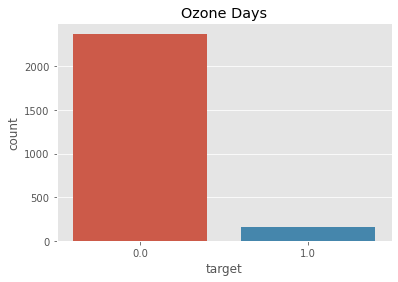

In [635]:
fig=sns.countplot(ozone.target)
fig=plt.title("Ozone Days")

In [636]:
pd.crosstab(ozone.target, "count")

col_0,count
target,
0.0,2374
1.0,160


Graphical representation by year:

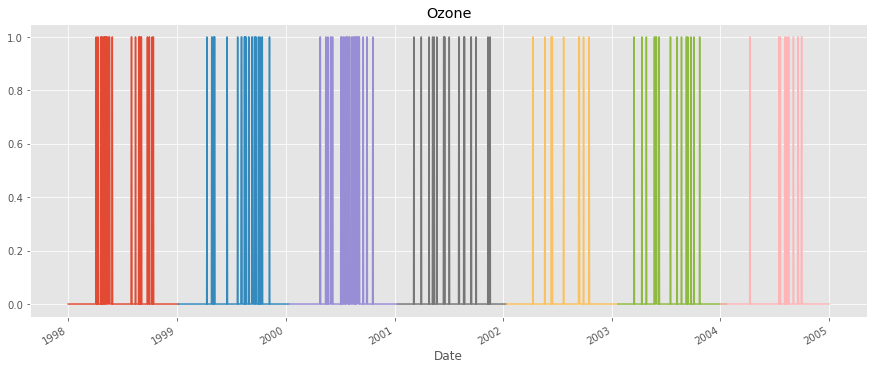

In [637]:
fig=plt.figure(figsize=(15,6))
fig=plt.subplot()
fig = ozone.target[:365].plot()
fig = ozone.target[365:730].plot()
fig = ozone.target[730:1095].plot()
fig = ozone.target[1095:1460].plot()
fig = ozone.target[1460:1825].plot()
fig = ozone.target[1825:2190].plot()
fig=ozone.target[-365:].plot()
fig=plt.title("Ozone")

### 3.4 Predictors

The dataset contains so many variables because of Wind Speed and Tempeture: *There are records for each hour of the day.* Nevertheless, its average variables are also in the data so there is not need to plot all series. Similar to U50-U70, T85-T70 etc.



* The missing values from WSR & Temperature correspond to the second half of 2002. For the remaining variables are missing at Random (So interpolation would be a good method, except for WSR and Temperature).

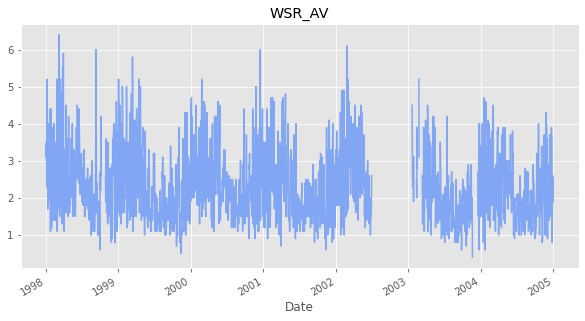

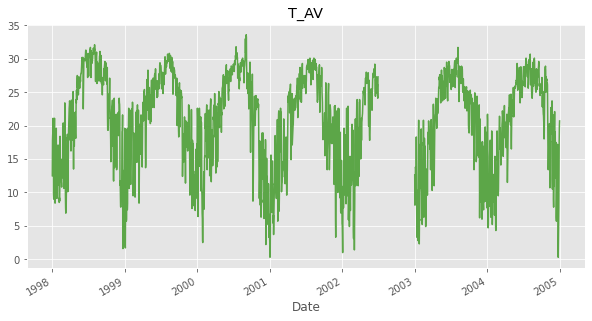

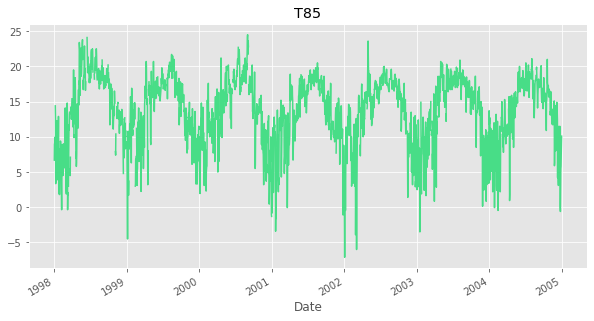

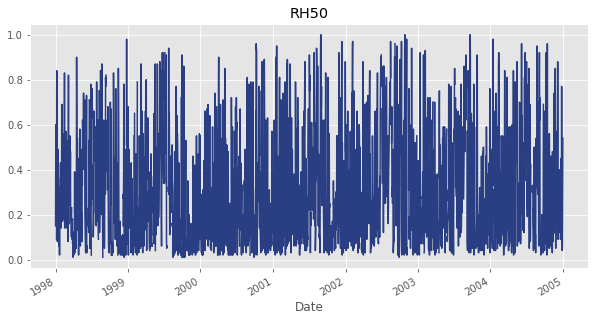

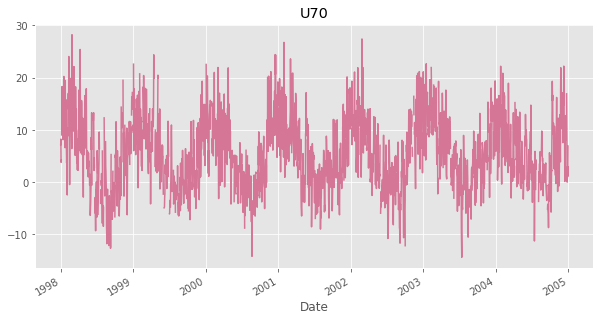

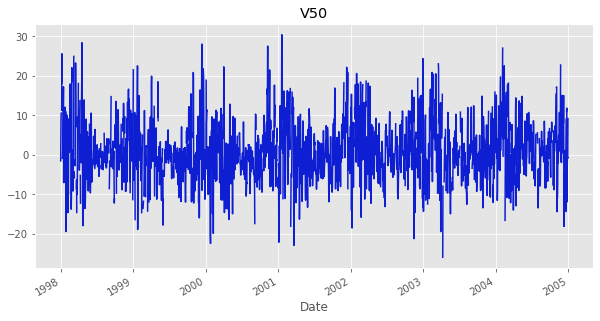

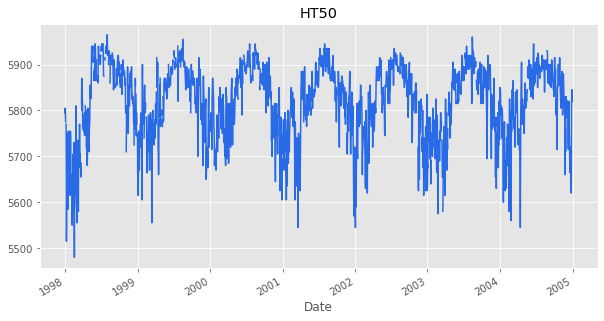

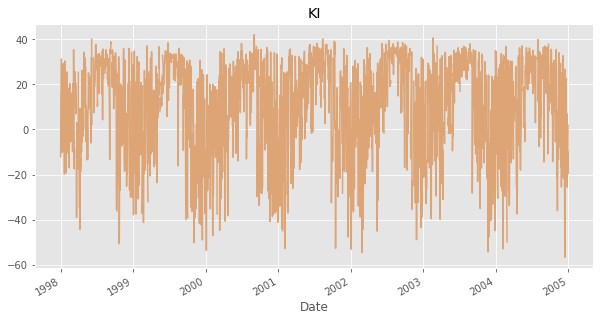

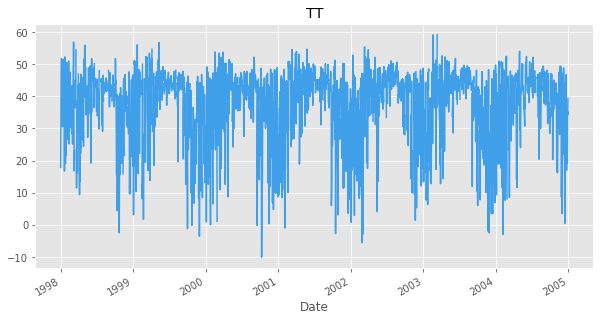

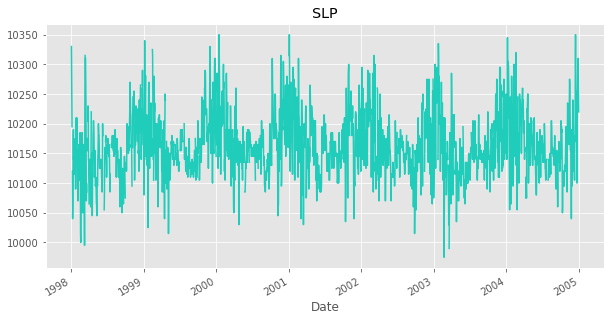

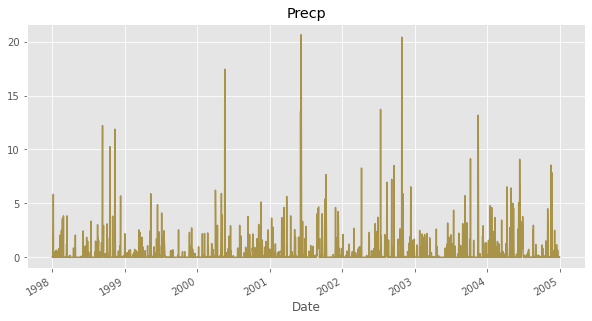

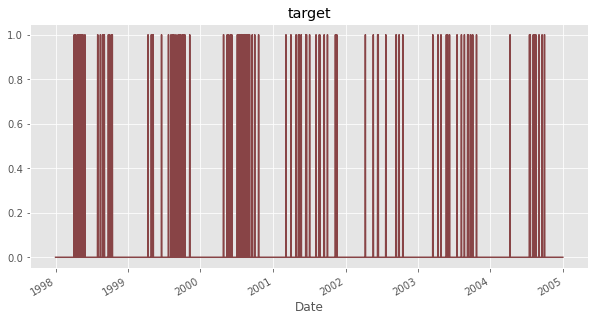

In [638]:
series = ["WSR_AV","T_AV","T85","RH50","U70","V50","HT50","KI","TT","SLP","Precp","target"] # Just a few...
for i in series:
    fig=plt.figure(figsize=(10,5))
    fig=ozone[i].plot(c=np.random.rand(3,))
    fig=plt.title(i)
    fig=None

# 4. Imputation

For time series, interpolation is a fast and good way of imputation:
   - Having values for t-1 = 10 & t-3 = 20, while t-2 is missing, the replacement will be the mean between t-1 and t-3; t-2=15.
However it's not clear for temperature & WSR.
- In the plots, it seems that for WSR it not going to be very accurate.

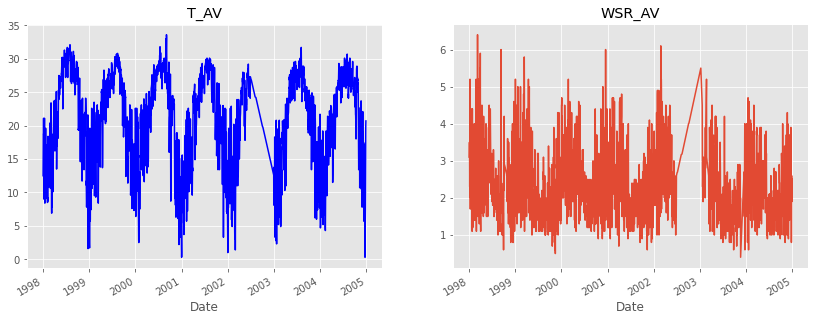

In [639]:
fig=plt.figure(figsize=(14,5))
fig=plt.subplot(1,2,1)
fig=ozone.T_AV.interpolate().plot(c="blue",title="T_AV")
fig=plt.subplot(1,2,2)
fig=ozone.WSR_AV.interpolate().plot(title="WSR_AV")

In [640]:
WSR_columns = filter_startswith(ozone.columns, "WSR")
len(WSR_columns)

26

In [641]:
ozone.iloc[:,26:]=ozone.drop(WSR_columns,axis=1).interpolate(method="linear",limit_direction='forward')
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
ozone[ozone.columns]=imputer.fit_transform(ozone)
ozone.isnull().sum()

WSR0      0
WSR1      0
WSR2      0
WSR3      0
WSR4      0
         ..
TT        0
SLP       0
SLP_      0
Precp     0
target    0
Length: 73, dtype: int64

For WSR it was preferred the mean.

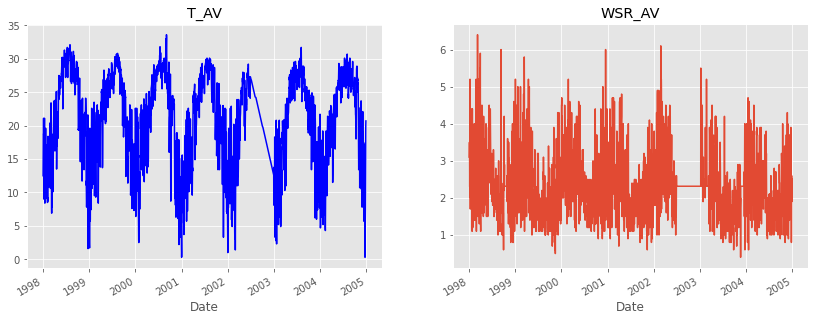

In [642]:
fig=plt.figure(figsize=(14,5))
fig=plt.subplot(1,2,1)
fig=ozone.T_AV.interpolate().plot(c="blue",title="T_AV")
fig=plt.subplot(1,2,2)
fig=ozone.WSR_AV.interpolate().plot(title="WSR_AV")

### 5 Linear Correlation

Having so many variables can make information redundant and increase the cost of computing. That is, the temperature at 00 in the morning, may be very similar to that of 1, therefore, one could make its average and remove a variable. 

**When the target variable is binary, the pearson correlation is not the best method, but it still works.**

- Note how temperatures at central times of the day are associated with a higher correlation with the target variable.
- That's why T_pk is also very correlated. There's not point to use all those variables having T_pk.
- Maybe the mean between T14,T15,T16.

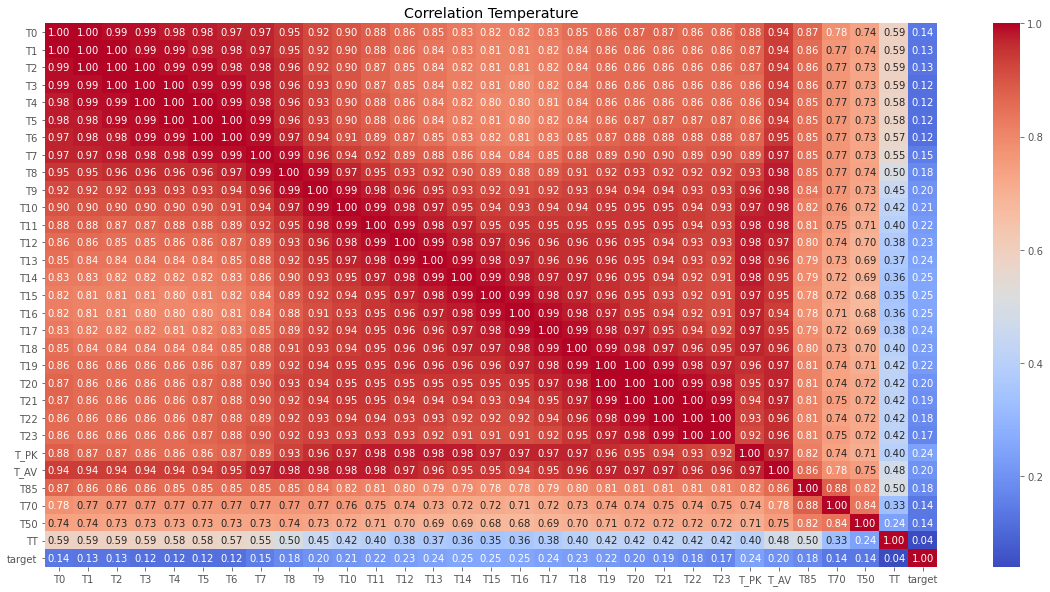

In [643]:
T_columns = filter_startswith(ozone.columns, "T")
T_columns = np.append(T_columns,"target")

corr = ozone[T_columns].corr()
fig = plt.figure(figsize=(20,10))
fig = sns.heatmap(round(corr,2), cmap="coolwarm",fmt='.2f',annot=True)
fig = plt.title("Correlation Temperature")

In [644]:
ozone["T14_16"]=(ozone.T14+ozone.T15+ozone.T16)/3
ozone[["target","T14_16", "T14","T15", "T16", "T_PK"]].corr("kendall")

,target,T14_16,T14,T15,T16,T_PK
target,1.000000,0.217010,0.216552,0.217591,0.214996,0.207097
T14_16,0.217010,1.000000,0.944631,0.975948,0.945214,0.909825
T14,0.216552,0.944631,1.000000,0.933546,0.891885,0.910878
T15,0.217591,0.975948,0.933546,1.000000,0.938125,0.900720
T16,0.214996,0.945214,0.891885,0.938125,1.000000,0.882755
T_PK,0.207097,0.909825,0.910878,0.900720,0.882755,1.000000


There seems to be more variety with WSR.

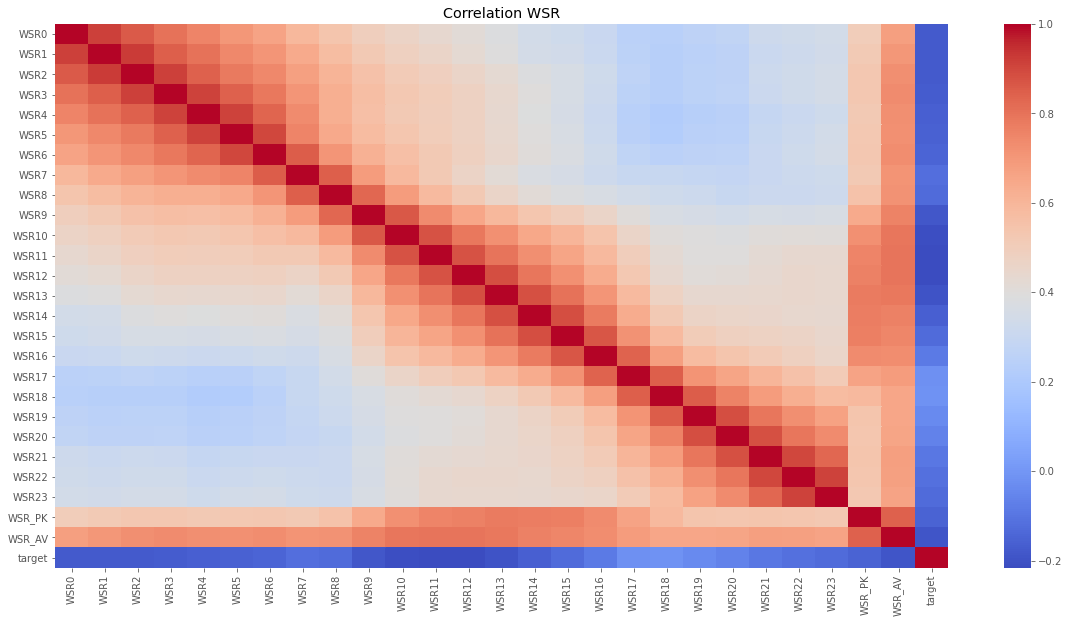

In [645]:
WSR_columns = filter_startswith(ozone.columns, "WSR")
WSR_columns = np.append(WSR_columns,"target")

corr = ozone[WSR_columns].corr()
fig = plt.figure(figsize=(20,10))
fig = sns.heatmap(round(corr,3), cmap="coolwarm",fmt='.2f')
fig = plt.title("Correlation WSR")

In [646]:
ozone["WSR10_13"]=(ozone.WSR10+ozone.WSR11+ozone.WSR12)/3

Remaining Variables:

- T_PK & T85 have a positive correlation of 0.88.
- KI & TT of 0.86.
- There are not strong linear relationship with the target variable. 

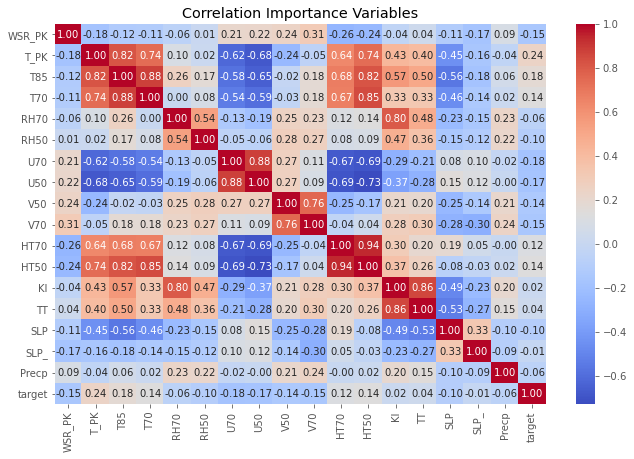

In [647]:
features = ["WSR_PK","T_PK","T85","T70","RH70","RH50","U70","U50","V50","V70","HT70","HT50","KI","TT","SLP","SLP_","Precp","target"]
corr = ozone[features].corr()
fig = plt.figure(figsize=(11,7))
fig = sns.heatmap(round(corr,2), cmap="coolwarm",fmt='.2f', annot=True)
fig = plt.title("Correlation Importance Variables")

### 6. Dimensional Reduction

T-NSE

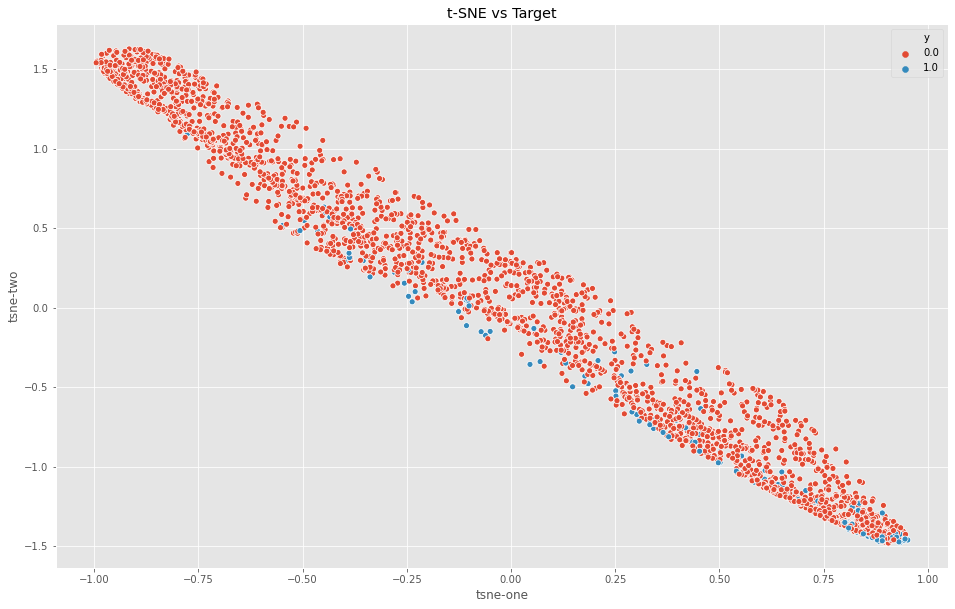

In [648]:
scaler=MinMaxScaler()
x=scaler.fit_transform(ozone.drop("target",axis=1))
tsne_fitting = TSNE(n_components=2, perplexity=25, n_iter=250, learning_rate=100, metric="braycurtis")
X_embedded = tsne_fitting.fit_transform(x)
plot_data = pd.DataFrame([])
plot_data['tsne-one'] = X_embedded[:,0]
plot_data['tsne-two'] = X_embedded[:,1]
plot_data['y'] = ozone.target.values
plt.figure(figsize=(16,10))
plt.title('t-SNE vs Target')
fig=sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="y",
    data=plot_data,
)

# 7 Feature Selection

A logical way to select variables would be to create all possible combinations of models, from more to less variables and get the best one. One way to approach this is to use a RandomForest that creates X tree models in which the variables are randomly selected to build the trees and not all of them come in at once. Also, not all the observations are used to build the trees, so they can be evaluated with what is known as OutOfBag, which are the observations that did not enter the model so they are honest.
RF can be applied to variable selection because it obtains the variables that most reduce the gini index. The impurity is understood when CARTs create heterogeneous groups, that is, that in their final nodes there are probabilities of 0.5 and 0.5 for the two classes, since it does not discriminate them. On the other hand, if a node distributes with 0.9 and 0.1, is a homogeneous group and that is what is interesting to classify. 
The number of variables entering the trees by default is the square root of the number of variables and 500 trees will be perform. 

In [649]:
predictors = ["WSR_PK","T_PK","T14_16","WSR10_13","RH70","RH50","U70","U50","V50","V70","HT70","HT50","KI","TT","SLP","SLP_","Precp"]
X = supervised_lag(ozone[predictors], 3)
y = ozone.target.values[3:]
X.head(2)

,WSR_PK-3,WSR_PK-2,WSR_PK-1,WSR_PK,T_PK-3,T_PK-2,T_PK-1,T_PK,T14_16-3,T14_16-2,...,SLP-1,SLP,SLP_-3,SLP_-2,SLP_-1,SLP_,Precp-3,Precp-2,Precp-1,Precp
0,5.5,5.5,5.6,4.7,19.1,22.4,22.2,19.6,18.766667,21.766667,...,10235.0,10195.0,-55.0,-55.0,-40.0,-40.000000,0.0,0.0,0.00,2.08
1,5.5,5.6,4.7,3.7,22.4,22.2,19.6,26.0,21.766667,21.866667,...,10195.0,10157.5,-55.0,-40.0,-40.0,-53.333333,0.0,0.0,2.08,0.58


In [650]:
impRF = RandomForestClassifier(n_estimators=500, criterion="gini", random_state=123)
impRF.fit(X,y)

imp = {}
for i in range(len(X.columns)):
    imp[X.columns[i]] = [impRF.feature_importances_[i]]
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).head(25).style.background_gradient()

,Importance
WSR10_13,0.050863
T14_16,0.039411
T_PK,0.033046
T14_16-1,0.027504
V70-1,0.025536
T_PK-1,0.024110
WSR_PK-1,0.022073
RH50,0.022040
U70-1,0.020613
V70,0.020284


# 8 Feature Engenineering

Time variables are going to be created in order to capture the posible seasonality.

In [651]:
ozone["month"]=pd.DataFrame(ozone.index).Date.apply(lambda x: x.strftime("%b")).values
dummy_month=pd.get_dummies(ozone.month)
ozone=pd.concat([ozone.drop("month",axis=1),dummy_month],axis=1)

Final:

In [652]:
final_predictors = ["WSR10_13","T14_16", "U70", "RH50","V70", "TT", "KI"]
final_predictors = np.append(final_predictors, dummy_month.columns)
final_predictors

array(['WSR10_13', 'T14_16', 'U70', 'RH50', 'V70', 'TT', 'KI', 'Apr',
       'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov',
       'Oct', 'Sep'], dtype=object)

# 9 Train/Test

We are going to predict the last 1 and 9 months. Why not 2 years? Because from January to March, target is always 0 and the target variable may be similarly distributed in both train & test.
![](dist_test.png)

365*2 = 730 days, -3 months (90 days) = 640 days.

In [653]:
train_X, train_y, test_X, test_y = ts_train_test(ozone, final_predictors, "target", 640)

In [654]:
train_y.tail(1)

Date
2003-03-31    0.0
Name: target, dtype: float64

In [655]:
test_X.head(1)

,WSR10_13,T14_16,U70,RH50,V70,TT,KI,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,,,,,
2003-04-01,4.966667,21.666667,6.86,0.03,0.9,24.8,-12.0,1,0,0,0,0,0,0,0,0,0,0,0


In [656]:
pd.crosstab(train_y,"count",normalize=True)

col_0,count
target,
0.0,0.930306
1.0,0.069694


In [657]:
pd.crosstab(test_y,"count",normalize=True)

col_0,count
target,
0.0,0.95625
1.0,0.04375


# 10 Data Preparation for NN

### 10.1 Scale Data

It is important to train the scaler with the minimum and maximum of train, and transfer them to the test. If not, data leak could occur, that is, give information of the test data (its min and max) to the model and it could not be validated in an honest way.

In [658]:
scaler = MinMaxScaler().fit(train_X)
train_X[final_predictors] = scaler.transform(train_X)
test_X[final_predictors] = scaler.transform(test_X)

In [659]:
train_X.columns

Index(['WSR10_13', 'T14_16', 'U70', 'RH50', 'V70', 'TT', 'KI', 'Apr', 'Aug',
       'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

### 10.2 Lag the data & Reshape

Nº obs, 3 time steps (sequence) (t-2,t-1,t) & 17 variables.

In [660]:
train_X_R = ts_lag(train_X, 2)
print(train_X_R.shape)
train_y=train_y[2:]
test_X_R = ts_lag_test(train_X,test_X,2)
test_X_R.shape

(1892, 3, 19)


(640, 3, 19)

# 11 Model & Evaluation

- `Batch`: It the set of observations that are used in each backpropagation iteration. At the end of each iteration, the parameters will be updated and goes the next batch.
- `epoch`: It is the number of times that the backpropagation algorithm goes through the whole train set.

In [661]:
model, history, = make_LSTM(train_X_R, train_y, test_X_R, test_y, units=16, epochs=50, batch_size=64,seed=303)
evaluate_nn(train_X_R, test_X_R, test_y)
model.evaluate(test_X_R,test_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.1411 - auc: 0.9018


[0.14107319712638855, 0.901814877986908]

- There is not much different betweek Test & Train. Usually test is above train in Loss... Maybe it is a signal of **underfiting.**
- AUC starts below in test and then is above train.
- Maybe around 22 epochs are enough. However, it does not seem to overfit.
- The AUC is high so the model is not predicting randomly.

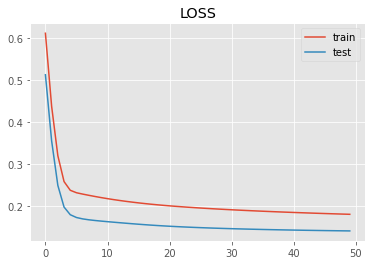

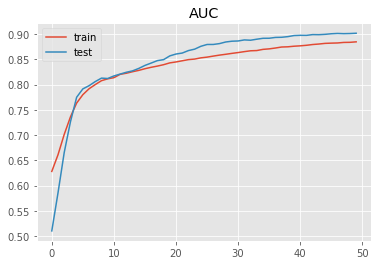

- AUC: 0.9028944911297853
- AVG Recall: 0.530812324929972


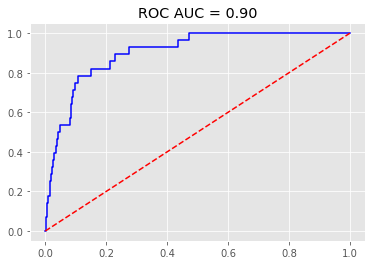

In [662]:
plot_loss(history)
plot_auc(history)
plot_roc(test_y, model.predict(test_X_R))

# 12 Grid Search

In [663]:
units = [8,16,32]
epochs=[32,64,128,256]
batch_size=[32,64,128]
tune_nn(units=units, epochs=epochs, batch_size=batch_size)

8 32 32
20/20 [==============================] - 0s 2ms/step - loss: 0.1428 - auc: 0.8787
8 32 64
20/20 [==============================] - 0s 2ms/step - loss: 0.1504 - auc: 0.8692
8 32 128
20/20 [==============================] - 0s 1ms/step - loss: 0.1585 - auc: 0.8643
8 64 32
20/20 [==============================] - 0s 2ms/step - loss: 0.1384 - auc: 0.8996
8 64 64
20/20 [==============================] - 0s 2ms/step - loss: 0.1447 - auc: 0.8891
8 64 128
20/20 [==============================] - 0s 2ms/step - loss: 0.1494 - auc: 0.8762
8 128 32
20/20 [==============================] - 0s 2ms/step - loss: 0.1415 - auc: 0.9111
8 128 64
20/20 [==============================] - 0s 2ms/step - loss: 0.1381 - auc: 0.9111
8 128 128
20/20 [==============================] - 0s 2ms/step - loss: 0.1431 - auc: 0.8988
8 256 32
20/20 [==============================] - 0s 2ms/step - loss: 0.1484 - auc: 0.9179
8 256 64
20/20 [==============================] - 0s 902us/step - loss: 0.1406 - auc: 0.9208


,units,epochs,batch_size,AUC
0,8,32,32,0.878210
1,8,32,64,0.868464
2,8,32,128,0.859740
3,8,64,32,0.901742
4,8,64,64,0.889531
5,8,64,128,0.876196
6,8,128,32,0.915076
7,8,128,64,0.911458
8,8,128,128,0.899962
9,8,256,32,0.922984


### 12. Try the best model

In [683]:
model, history, = make_LSTM(train_X_R, train_y, test_X_R, test_y, units=32, epochs=256, batch_size=128,seed=303)
model.evaluate(test_X_R,test_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.1458 - auc: 0.9211


[0.14576290547847748, 0.9210726618766785]

- **Effectively complicating the model, the loss of train and test is approaching.**
- AUC is 0.92 whereas the simpler model was 0.88
- Maybe 200 epochs would have been better.

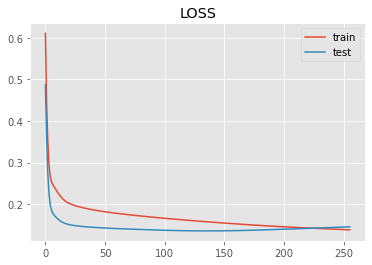

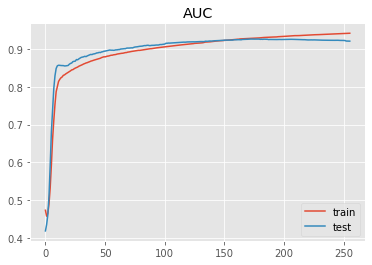

- AUC: 0.9214519140989729
- AVG Recall: 0.5498338870431895


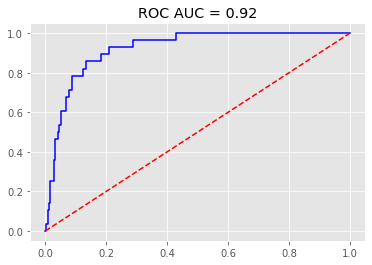

In [684]:
plot_loss(history)
plot_auc(history)
plot_roc(test_y, model.predict(test_X_R))

In [685]:
y_prob=model.predict(test_X_R)
Find_Optimal_Cutoff(test_y,y_prob)

[0.19772955775260925]

In [686]:
y_pred=np.where(y_prob>0.1977,1,0) # Optimum cut

How are the predictions the for the last year? 

- They seem to be good, even the ones that fail, are close to being high ozone days. It has defenitely learn6 that the ozone is low in winter.

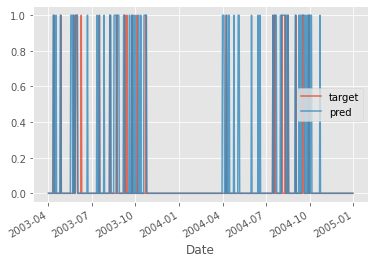

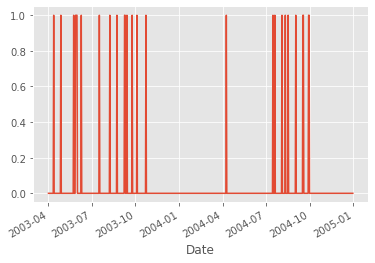

In [687]:
visual=pd.DataFrame()
visual["target"]=ozone.target[-640:]
visual["pred"]=y_pred
fig=visual.plot(alpha=.8)
fig=plt.figure()
fig=visual.target.plot()

Overall, it's a proper model. Despite the target is imbalanced, it has a nice recall 0.86, therefore, its ability to recognize true positives is high

In [688]:
confusion_matrix(test_y,y_pred,labels=(1,0))

array([[ 24,   4],
       [ 81, 531]], dtype=int64)

In [670]:
print(f"Acc: {(24+531)/(24+531+81+4)}, Recall:{24/(24+4)}, Especificidad: {531/(531+81)}")

Acc: 0.8671875, Recall:0.8571428571428571, Especificidad: 0.8676470588235294


# 13. Stacked LSTM

While not a bad model, an attempt will be made to improve the underfiting situation. 
Multiple hidden LSTM layers can be stacked. The problem is that the output of a LSTM will be two-dimensional, nontheless, it can be tackle by setting the return sequences=True.

- Introducing activation function in LSTM layer did not improve the model.

In [671]:
def make_Stacked_LSTM(train_X,train_y,test_X,test_y,units,epochs,batch_size,seed):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(LSTM(units, return_sequences=True,
                      input_shape=(train_X.shape[1],train_X.shape[2]),kernel_initializer="he_uniform"
                  ))
    model.add(LSTM(units,kernel_initializer="he_uniform"))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="BinaryCrossentropy", optimizer="rmsprop", metrics=["AUC"])
    history=model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,
                         validation_data=(test_X,test_y), verbose=0, shuffle = False)
 
    return model, history

A little bit better.

In [672]:
model, history, = make_Stacked_LSTM(train_X_R, train_y, test_X_R, test_y, units=32, epochs=115, batch_size=128,seed=303)
model.evaluate(test_X_R,test_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.1444 - auc: 0.9245


[0.14438031613826752, 0.9245447516441345]

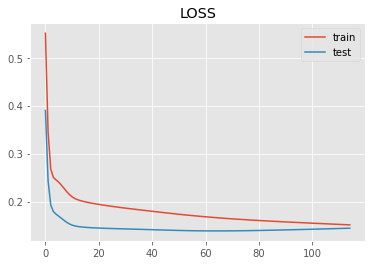

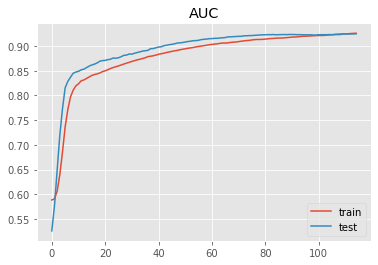

- AUC: 0.924077964519141
- AVG Recall: 0.5476190476190476


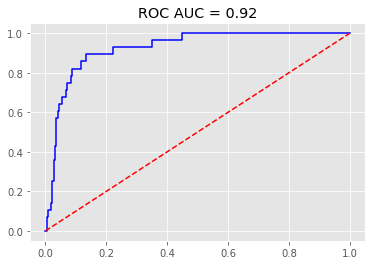

In [673]:
plot_loss(history)
plot_auc(history)
plot_roc(test_y, model.predict(test_X_R))

*******************************************************

# 14 To improve:

1. Introduce class_weight for imbalance data.
2. Use a sophisticated imputer algorithm.
3. More feature engineering: Include weeks...
4. Try CNN+LSTM models.

References: Deep Learning for
Time Series Forecasting
Predict the Future with MLPs,
CNNs and LSTMs in Python
Jason Brownlee